In [1]:
import numpy as np
import sys
import time
import random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm')

%load_ext autoreload
%autoreload 2

In [2]:
from word2vec_eltdm.word2vec_numpy import (
    Tokenizer, VocabCreator, DataLoader, TokenCleaner, Preprocessor,
    Subsampler, SimpleWord2Vec, Optimizer, CrossEntropy, train, validate, NegWord2Vec,
    NegativeSamplingLoss, OptimizeNSL
)

## Get data and create vocab

In [3]:
datapath = "../data/text8.txt"

RATIO = 1
tokenizer = Tokenizer(datapath)
token_cleaner = TokenCleaner(freq_threshold=5)
vocab_creator = VocabCreator()
text8_dataset = Preprocessor(tokenizer, token_cleaner, vocab_creator, RATIO).preprocess()

In [4]:
print("Size of our vocabulary:", len(text8_dataset.tokens_to_id))

Size of our vocabulary: 62954


In [5]:
print("Number of tokens in our train dataset:", len(text8_dataset.train_tokens))

Number of tokens in our train dataset: 8452826


In [6]:
print("Number of tokens in our val dataset:", len(text8_dataset.val_tokens))

Number of tokens in our val dataset: 1056603


In [7]:
print("Number of tokens in our test dataset:", len(text8_dataset.test_tokens))

Number of tokens in our test dataset: 1056604


## Subsampling of frequent words, as in Mikolov 2013.

In [8]:
subsampler = Subsampler(text8_dataset.train_tokens)
text8_dataset.train_tokens, text8_dataset.frequencies = subsampler.subsample()

In [9]:
print("Size of our vocabulary after subsampling of frequent words, for train:", len(text8_dataset.tokens_to_id))

Size of our vocabulary after subsampling of frequent words, for train: 62954


In [10]:
print("Number of tokens in train dataset:", len(text8_dataset.train_tokens))

Number of tokens in train dataset: 3007924


## DataLoader

In [11]:
window = 5
batch_size = 256
train_dataloader = DataLoader(text8_dataset, text8_dataset.train_tokens, window, batch_size)
val_dataloader = DataLoader(text8_dataset, text8_dataset.val_tokens, window, batch_size)
test_dataloader = DataLoader(text8_dataset, text8_dataset.test_tokens, window, batch_size)

## Model

In [12]:
# defining the parameters
len_vocab = len(text8_dataset.tokens_to_id)
hidden_size = 500
embedding_size = 300
learning_rate = 1e-3
n_samples = 5

# Get our noise distribution
word_freqs = np.array(sorted(text8_dataset.frequencies.values(), reverse=True))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75))

# instantiate the model
model = NegWord2Vec(
    len_vocab,
    hidden_size,
    embedding_size,
    noise_dist=noise_dist
)
model.initialize_weights()
#model.initialize_embeddings()

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = OptimizeNSL(model,learning_rate)

## Training

In [13]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer):
    train_loss = 0.0
    for i, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        X, y = batch["X"], batch["Y"]
        h = model.forward_input(X)
        u = model.forward_output(y)
        noise_vector = model.forward_noise(X.shape[1], n_samples)

        # negative sampling loss
        loss, grad_W1, grad_W2 = criterion(model, h, u, noise_vector, y)
        optimizer.step(grad_W1, grad_W2)

        train_loss += loss

        if i % 10000 == 0:
            print(
                "Current Training Loss {:.6}".format(loss)
            )
            validation_loss = validate(model, val_dataloader, criterion)

    train_loss /= len(train_dataloader)
    return train_loss, validation_loss


def update_best_loss(model, val_loss):
    # Update the model and best loss if we see improvements.
    if not model.best_val_loss or val_loss < model.best_val_loss:
        model.best_val_loss = val_loss
        model.best_W1 = model.W1
        model.best_W2 = model.W2


def validate(model, dataloader, criterion):
    model.eval()
    validation_loss = 0
    for i, batch in enumerate(tqdm(dataloader)):
        X, y = batch["X"], batch["Y"]
        h = model.forward_input(X)
        u = model.forward_output(y)
        noise_vector = model.forward_noise(X.shape[1], n_samples)
        
        loss, grad_W1, grad_W2 = criterion(model, h, u, noise_vector, y)
        validation_loss += loss

    validation_loss /= len(dataloader)

    # Keep track of the best model
    update_best_loss(model, validation_loss)

    print("Validation Loss: ", validation_loss)

    return validation_loss

In [14]:
# train for some number of epochs
epochs = 20
train_loss_history = []
val_loss_history = []
tbar = trange(epochs)
for epoch in tbar:
    print(f"###################### EPOCH {epoch} ###########################")
    train_loss, val_loss= train(model, train_dataloader, val_dataloader, criterion, optimizer)
    print("Training loss:", train_loss)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

###################### EPOCH 0 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 14.6801


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  14.869461873277565
Current Training Loss 14.1082


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  13.116324308008695
Training loss: 14.08268031935991
###################### EPOCH 1 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 13.6374


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  12.831732084417629
Current Training Loss 13.0158


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  11.679217303027023
Training loss: 13.344222960036937
###################### EPOCH 2 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 13.1394


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  11.501780897718007
Current Training Loss 12.5867


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  10.782424696903732
Training loss: 12.750535662305952
###################### EPOCH 3 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 12.2618


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  10.668395962848278
Current Training Loss 12.2274


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  10.155968836371782
Training loss: 12.262452471919666
###################### EPOCH 4 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 11.7526


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  10.074156244338178
Current Training Loss 11.9496


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  9.667000201870568
Training loss: 11.836847309481074
###################### EPOCH 5 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 11.7501


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  9.59735796891468
Current Training Loss 11.7372


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  9.243365776869176
Training loss: 11.453614283826676
###################### EPOCH 6 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 11.4202


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  9.187944088791763
Current Training Loss 11.409


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  8.870622493196274
Training loss: 11.10515174055696
###################### EPOCH 7 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 10.8098


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  8.821713389689844
Current Training Loss 10.7048


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  8.546884155184081
Training loss: 10.784749054828056
###################### EPOCH 8 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 10.6311


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  8.499482295744366
Current Training Loss 10.7104


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  8.250168188738611
Training loss: 10.488368721481589
###################### EPOCH 9 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 10.1236


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  8.207874506109231
Current Training Loss 10.264


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.9879345211655535
Training loss: 10.214851659034743
###################### EPOCH 10 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 9.77746


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.946090921417877
Current Training Loss 10.1275


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.746784955443794
Training loss: 9.96527801273306
###################### EPOCH 11 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 9.77772


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.714804888572935
Current Training Loss 9.86074


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.532401692769736
Training loss: 9.732579736129106
###################### EPOCH 12 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 9.3693


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.501993953395459
Current Training Loss 9.93076


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.340305559304628
Training loss: 9.51658314414154
###################### EPOCH 13 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 9.20749


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.316334635486842
Current Training Loss 9.51936


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.164904398476177
Training loss: 9.316807984225314
###################### EPOCH 14 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 9.3475


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.145100398875387
Current Training Loss 9.43156


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  7.0062056920813465
Training loss: 9.130463298652975
###################### EPOCH 15 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 8.87594


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.986976002048798
Current Training Loss 9.20154


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.869778619852705
Training loss: 8.960377499012079
###################### EPOCH 16 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 8.86265


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.846604948472947
Current Training Loss 8.97262


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.734564239847356
Training loss: 8.800103224345504
###################### EPOCH 17 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 8.75855


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.716822168851119
Current Training Loss 8.76991


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.614458544652669
Training loss: 8.64839856268855
###################### EPOCH 18 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 8.57429


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.598265133176966
Current Training Loss 8.95094


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.506127064334648
Training loss: 8.510430430293066
###################### EPOCH 19 ###########################


  0%|          | 0/11749 [00:00<?, ?it/s]

Current Training Loss 8.46192


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.48958484630523
Current Training Loss 8.54737


  0%|          | 0/4127 [00:00<?, ?it/s]

Validation Loss:  6.403261148836892
Training loss: 8.37909329125085


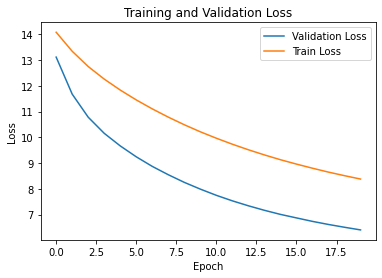

In [15]:
plt.plot(val_loss_history, label = "Validation Loss")
plt.plot(train_loss_history, label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend() 
plt.title('Training and Validation Loss')
plt.show() 

In [16]:
print(model.best_W1)

[[-0.02778928 -0.03556566  0.01145718 ... -0.01361473 -0.00495206
   0.02172172]
 [ 0.00533436  0.01103757 -0.01466153 ...  0.00495247  0.0606857
   0.01391757]
 [ 0.03738163 -0.00506805  0.02472496 ...  0.00598234 -0.01086081
   0.03626619]
 ...
 [-0.72286203 -0.09694165  0.96553946 ...  0.01099888  0.29670121
  -0.27046942]
 [ 0.90739978 -0.18445603 -0.25119557 ...  0.91523767  0.64842333
   0.39227108]
 [ 0.08128923 -0.64439505  0.46430686 ... -0.16109255  0.00672681
   0.6391701 ]]


In [17]:
print(model.best_W2)

[[-0.02756245 -0.03533976  0.0116297  ... -0.01386185 -0.00457364
   0.02145386]
 [ 0.00534539  0.01105899 -0.01465773 ...  0.00494573  0.06068846
   0.01391925]
 [ 0.03760502 -0.00498934  0.02548572 ...  0.00598501 -0.0106839
   0.03601982]
 ...
 [-0.72263242 -0.09717603  0.96486998 ...  0.00984305  0.2976744
  -0.26983875]
 [ 0.90732042 -0.18421459 -0.25215264 ...  0.91499198  0.64683827
   0.39264241]
 [-0.66018658 -0.39112116 -0.8292919  ...  0.36237342 -0.10930143
   0.07381323]]


## Results on test set